# ML contest

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score

In [5]:
sns.set(rc={'figure.figsize': (9, 6)})

In [6]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

## data preprocessing

In [7]:
events_data.head()

step_id   timestamp      action  user_id
0    32815  1434340848      viewed    17632
1    32815  1434340848      passed    17632
2    32815  1434340848  discovered    17632
3    32811  1434340895  discovered    17632
4    32811  1434340895      viewed    17632

In [8]:
submissions_data.head()

step_id   timestamp submission_status  user_id
0    31971  1434349275           correct    15853
1    31972  1434348300           correct    15853
2    31972  1478852149             wrong    15853
3    31972  1478852164           correct    15853
4    31976  1434348123             wrong    15853

In [9]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [10]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [11]:
events_data.head()

step_id   timestamp      action  user_id                date
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48
1    32815  1434340848      passed    17632 2015-06-15 04:00:48
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35

In [12]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [13]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [14]:
events_data['day'] = events_data.date.dt.date

In [15]:
events_data.head()

step_id   timestamp      action  user_id                date         day
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15

In [16]:
events_data.groupby('day')\
          .user_id.nunique()

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
             ... 
2018-05-15    145
2018-05-16    155
2018-05-17    165
2018-05-18    126
2018-05-19    131
Name: user_id, Length: 1070, dtype: int64

<Axes: xlabel='day'>

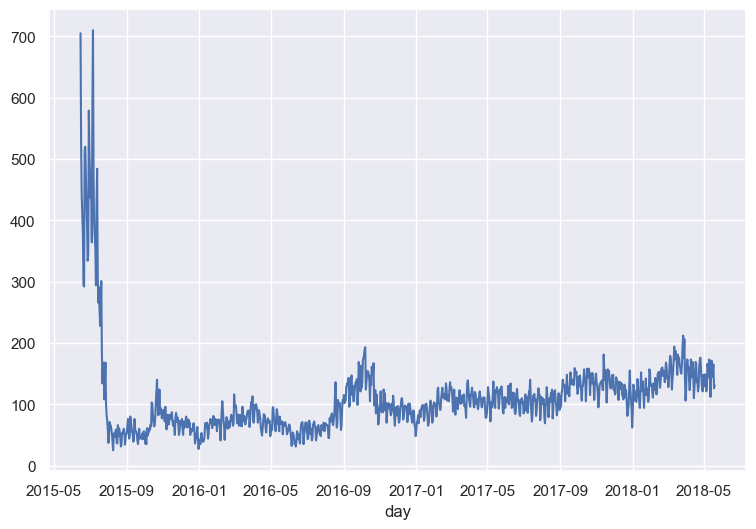

In [17]:
events_data.groupby('day')\
          .user_id.nunique().plot()

In [18]:
events_data.head()

step_id   timestamp      action  user_id                date         day
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15

In [19]:
# wrong resolve
counts_passed_step = events_data[events_data.action == 'passed']\
          .groupby('user_id', as_index=False)\
          .agg({'step_id': 'count'})\
          .rename(columns={'step_id': 'counts'})

In [20]:
counts_passed_step.head()

user_id  counts
0        2       9
1        3      87
2        5      11
3        7       1
4        8      84

<Axes: >

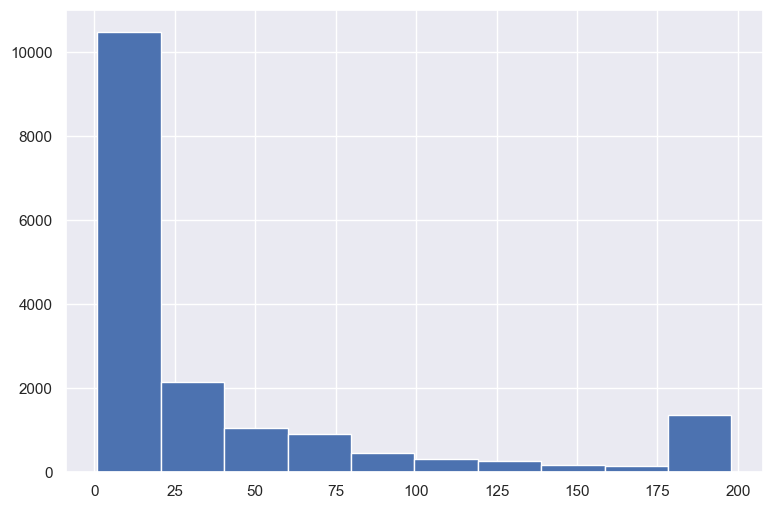

In [21]:
counts_passed_step.counts.hist()

In [22]:
counts_passed_step.counts.min()

1

In [23]:
events_data.head()

step_id   timestamp      action  user_id                date         day
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15

In [24]:
users_events_data = events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                       fill_value=0).reset_index()

In [25]:
users_events_data.head()

action  user_id  discovered  passed  started_attempt  viewed
0             1           1       0                0       1
1             2           9       9                2      10
2             3          91      87               30     192
3             5          11      11                4      12
4             7           1       1                0       1

In [26]:
users_events_data.passed.min()

0

<Axes: >

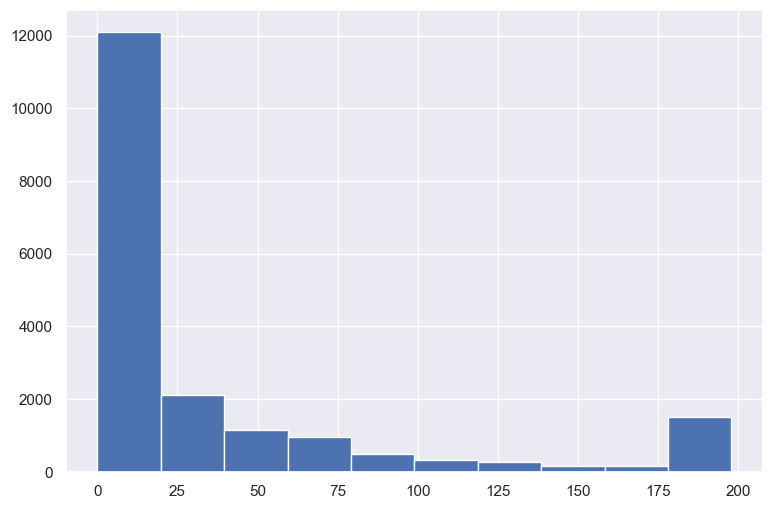

In [27]:
users_events_data.discovered.hist()

In [28]:
submissions_data.head()

step_id   timestamp submission_status  user_id
0    31971  1434349275           correct    15853
1    31972  1434348300           correct    15853
2    31972  1478852149             wrong    15853
3    31972  1478852164           correct    15853
4    31976  1434348123             wrong    15853

In [29]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [30]:
submissions_data.head()

step_id   timestamp submission_status  user_id                date   
0    31971  1434349275           correct    15853 2015-06-15 06:21:15  \
1    31972  1434348300           correct    15853 2015-06-15 06:05:00   
2    31972  1478852149             wrong    15853 2016-11-11 08:15:49   
3    31972  1478852164           correct    15853 2016-11-11 08:16:04   
4    31976  1434348123             wrong    15853 2015-06-15 06:02:03   

          day  
0  2015-06-15  
1  2015-06-15  
2  2016-11-11  
3  2016-11-11  
4  2015-06-15

In [31]:
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',
                       fill_value=0).reset_index()

In [32]:
users_scores.head()

submission_status  user_id  correct  wrong
0                        2        2      0
1                        3       29     23
2                        5        2      2
3                        8        9     21
4                       14        0      1

In [33]:
events_data.head()

step_id   timestamp      action  user_id                date         day
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15

In [34]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).head()

user_id         day   timestamp
0     17632  2015-06-15  1434340848
36    12494  2015-06-15  1434341931
59      442  2015-06-15  1434342029
62    22254  2015-06-15  1434342042
94     6646  2015-06-15  1434342230

In [35]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
                                           .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [36]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
                                           .groupby('user_id')['timestamp'].apply(list)\
                                           .apply(np.diff).head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [37]:
gaps_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset='day')\
                                           .groupby('user_id')['timestamp'].apply(list)\
                                           .apply(np.diff).values

In [38]:
gaps_data = pd.Series(np.concatenate(gaps_data, axis=0))

In [39]:
gaps_data = gaps_data / (24*60*60)

<Axes: >

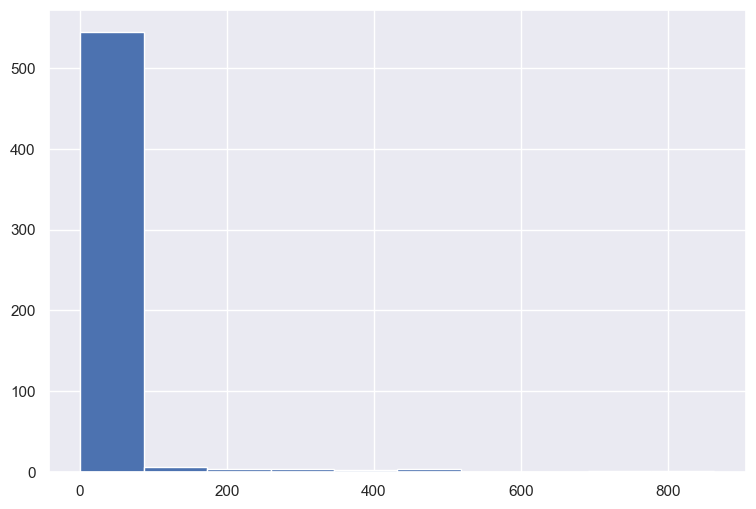

In [40]:
gaps_data.hist()

<Axes: >

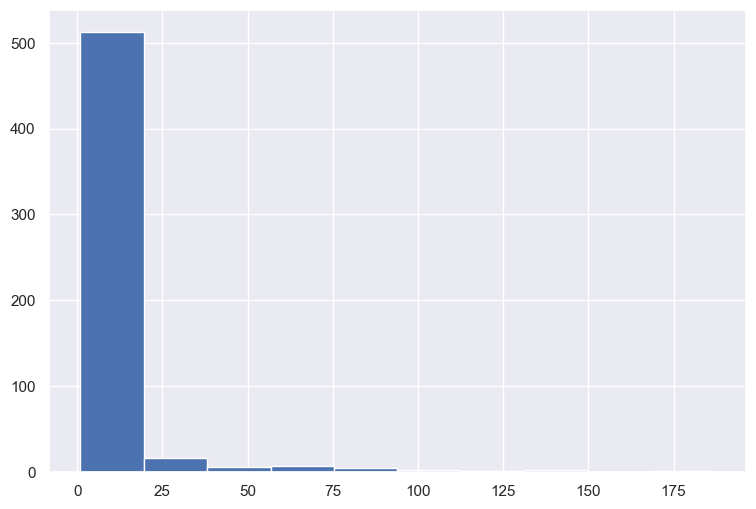

In [41]:
gaps_data[gaps_data < 200].hist()

In [42]:
gaps_data.quantile(0.90)

15.203456018518564

In [43]:
events_data.tail()

step_id   timestamp      action  user_id                date   
3480698    33375  1526772685      viewed    11677 2018-05-19 23:31:25  \
3480699    32815  1526772750      viewed     5198 2018-05-19 23:32:30   
3480700    32815  1526772750  discovered     5198 2018-05-19 23:32:30   
3480701    32815  1526772750      passed     5198 2018-05-19 23:32:30   
3480702    33892  1526772811      viewed    18526 2018-05-19 23:33:31   

                day  
3480698  2018-05-19  
3480699  2018-05-19  
3480700  2018-05-19  
3480701  2018-05-19  
3480702  2018-05-19

In [44]:
now = events_data.timestamp.max()
drop_out_treshhold = 30*24*60*60

In [45]:
users_data = events_data.groupby('user_id', as_index=False)\
                       .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [46]:
users_data.head()

user_id  last_timestamp
0        1      1472827464
1        2      1519226966
2        3      1444581588
3        5      1499859939
4        7      1521634660

In [47]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshhold

In [48]:
users_data.head(10)

user_id  last_timestamp  is_gone_user
0        1      1472827464          True
1        2      1519226966          True
2        3      1444581588          True
3        5      1499859939          True
4        7      1521634660          True
5        8      1481466913          True
6        9      1484999497          True
7       11      1526140625         False
8       14      1436368676          True
9       16      1513162585          True

In [49]:
users_scores.head()

submission_status  user_id  correct  wrong
0                        2        2      0
1                        3       29     23
2                        5        2      2
3                        8        9     21
4                       14        0      1

In [50]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [51]:
users_data = users_data.fillna(0)

In [52]:
users_data = users_data.merge(users_events_data, how='outer')

In [53]:
users_data.head(10)

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed   
0        1      1472827464          True      0.0    0.0           1       0  \
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      0.0    0.0           1       1   
5        8      1481466913          True      9.0   21.0         109      84   
6        9      1484999497          True      0.0    0.0           3       3   
7       11      1526140625         False      0.0    0.0           1       0   
8       14      1436368676          True      0.0    1.0           4       3   
9       16      1513162585          True     77.0  106.0         196     196   

   started_attempt  viewed  
0                0       1  
1                2      10  
2               30     192  
3                4      12  
4                0       1  
5               37     156  
6                0       4  
7                1       1  
8                1       9  
9              108     651

In [54]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [55]:
users_days.head()

user_id  day
0        1    1
1        2    2
2        3    7
3        5    2
4        7    1

In [56]:
users_data = users_data.merge(users_days, how='outer')

In [57]:
users_data.head(10)

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed   
0        1      1472827464          True      0.0    0.0           1       0  \
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      0.0    0.0           1       1   
5        8      1481466913          True      9.0   21.0         109      84   
6        9      1484999497          True      0.0    0.0           3       3   
7       11      1526140625         False      0.0    0.0           1       0   
8       14      1436368676          True      0.0    1.0           4       3   
9       16      1513162585          True     77.0  106.0         196     196   

   started_attempt  viewed  day  
0                0       1    1  
1                2      10    2  
2               30     192    7  
3                4      12    2  
4                0       1    1  
5               37     156    2  
6                0       4    1  
7                1       1    1  
8                1       9    1  
9              108     651   21

In [58]:
users_data.user_id.nunique()

19234

In [59]:
events_data.user_id.nunique()

19234

In [60]:
users_data['passed_course'] = users_data.passed > 40

In [61]:
users_data.head(10)

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed   
0        1      1472827464          True      0.0    0.0           1       0  \
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      0.0    0.0           1       1   
5        8      1481466913          True      9.0   21.0         109      84   
6        9      1484999497          True      0.0    0.0           3       3   
7       11      1526140625         False      0.0    0.0           1       0   
8       14      1436368676          True      0.0    1.0           4       3   
9       16      1513162585          True     77.0  106.0         196     196   

   started_attempt  viewed  day  passed_course  
0                0       1    1          False  
1                2      10    2          False  
2               30     192    7           True  
3                4      12    2          False  
4                0       1    1          False  
5               37     156    2           True  
6                0       4    1          False  
7                1       1    1          False  
8                1       9    1          False  
9              108     651   21           True

In [62]:
users_data.groupby('passed_course').count()

user_id  last_timestamp  is_gone_user  correct  wrong   
passed_course                                                          
False            14596           14596         14596    14596  14596  \
True              4638            4638          4638     4638   4638   

               discovered  passed  started_attempt  viewed    day  
passed_course                                                      
False               14596   14596            14596   14596  14596  
True                 4638    4638             4638    4638   4638

In [63]:
users_data[users_data.passed_course].day.median()

13.0

<Axes: >

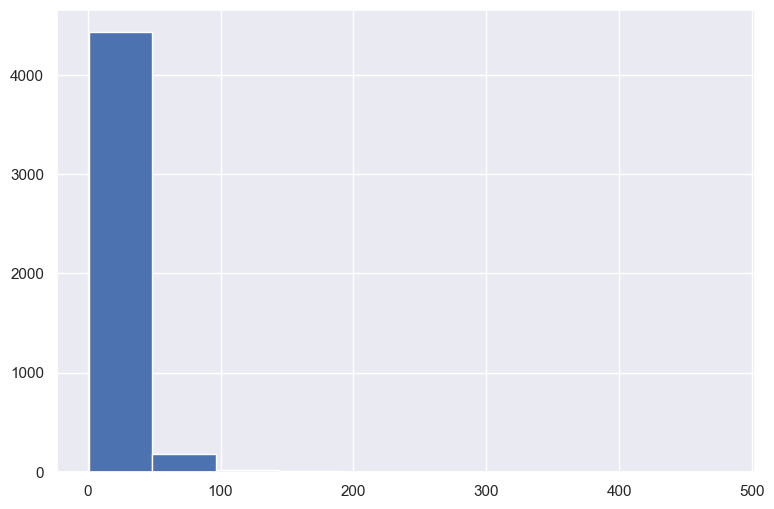

In [64]:
users_data[users_data.passed_course].day.hist()

In [65]:
user_min_time = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [66]:
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed   
0        1      1472827464          True      0.0    0.0           1       0  \
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      0.0    0.0           1       1   

   started_attempt  viewed  day  passed_course  min_timestamp  
0                0       1    1          False     1472827464  
1                2      10    2          False     1514383364  
2               30     192    7           True     1434358476  
3                4      12    2          False     1466156809  
4                0       1    1          False     1521634660

In [67]:
events_data.head()

step_id   timestamp      action  user_id                date         day
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15

In [68]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [69]:
learning_time_treshhold = 2 * 24 * 60 * 60
learning_time_treshhold

172800

In [70]:
user_learning_time_treshhold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshhold).map(str)

In [71]:
user_learning_time_treshhold.head()

0    1_1473000264
1    2_1514556164
2    3_1434531276
3    5_1466329609
4    7_1521807460
dtype: object

In [72]:
user_min_time['user_learning_time_treshhold'] = user_learning_time_treshhold

In [73]:
user_min_time.head()

user_id  min_timestamp user_learning_time_treshhold
0        1     1472827464                 1_1473000264
1        2     1514383364                 2_1514556164
2        3     1434358476                 3_1434531276
3        5     1466156809                 5_1466329609
4        7     1521634660                 7_1521807460

In [74]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshhold']], how='outer')

In [75]:
events_data.head()

step_id   timestamp      action  user_id                date         day   
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15  \
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15   
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15   
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15   
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15   

          user_time user_learning_time_treshhold  
0  17632_1434340848             17632_1434513648  
1  17632_1434340848             17632_1434513648  
2  17632_1434340848             17632_1434513648  
3  17632_1434340895             17632_1434513648  
4  17632_1434340895             17632_1434513648

In [76]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshhold]

In [77]:
events_data_train.head()

step_id   timestamp      action  user_id                date         day   
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15  \
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15   
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15   
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15   
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15   

          user_time user_learning_time_treshhold  
0  17632_1434340848             17632_1434513648  
1  17632_1434340848             17632_1434513648  
2  17632_1434340848             17632_1434513648  
3  17632_1434340895             17632_1434513648  
4  17632_1434340895             17632_1434513648

In [78]:
users_data.head(10)

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed   
0        1      1472827464          True      0.0    0.0           1       0  \
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      0.0    0.0           1       1   
5        8      1481466913          True      9.0   21.0         109      84   
6        9      1484999497          True      0.0    0.0           3       3   
7       11      1526140625         False      0.0    0.0           1       0   
8       14      1436368676          True      0.0    1.0           4       3   
9       16      1513162585          True     77.0  106.0         196     196   

   started_attempt  viewed  day  passed_course  min_timestamp  
0                0       1    1          False     1472827464  
1                2      10    2          False     1514383364  
2               30     192    7           True     1434358476  
3                4      12    2          False     1466156809  
4                0       1    1          False     1521634660  
5               37     156    2           True     1480603427  
6                0       4    1          False     1484999434  
7                1       1    1          False     1526140624  
8                1       9    1          False     1436366155  
9              108     651   21           True     1435674765

In [79]:
events_data_train.groupby('user_id').day.nunique().max()

3

In [80]:
submissions_data.head()

step_id   timestamp submission_status  user_id                date   
0    31971  1434349275           correct    15853 2015-06-15 06:21:15  \
1    31972  1434348300           correct    15853 2015-06-15 06:05:00   
2    31972  1478852149             wrong    15853 2016-11-11 08:15:49   
3    31972  1478852164           correct    15853 2016-11-11 08:16:04   
4    31976  1434348123             wrong    15853 2015-06-15 06:02:03   

          day  
0  2015-06-15  
1  2015-06-15  
2  2016-11-11  
3  2016-11-11  
4  2015-06-15

In [81]:
user_min_time.head()

user_id  min_timestamp user_learning_time_treshhold
0        1     1472827464                 1_1473000264
1        2     1514383364                 2_1514556164
2        3     1434358476                 3_1434531276
3        5     1466156809                 5_1466329609
4        7     1521634660                 7_1521807460

In [82]:
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshhold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_treshhold]
submissions_data_train.groupby('user_id').day.nunique().max()

3

In [83]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days'})

In [84]:
step_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

In [85]:
X = X.merge(step_tried, on='user_id', how='outer')

In [86]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                                               columns='submission_status',
                                               values='step_id',
                                               aggfunc='count',
                                               fill_value=0).reset_index())

In [87]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [88]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                                               columns='action',
                                               values='step_id',
                                               aggfunc='count',
                                               fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [89]:
X.shape

(19234, 7)

In [90]:
X = X.fillna(0)

In [91]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [92]:
X.head()

user_id  days  steps_tried  correct  wrong  correct_ratio  viewed   
0        2   1.0          2.0      2.0    0.0       1.000000       9  \
1        3   1.0          4.0      4.0    4.0       0.500000      20   
2        8   1.0         11.0      9.0   21.0       0.300000     154   
3       14   1.0          1.0      0.0    1.0       0.000000       9   
4       16   2.0         18.0     18.0   23.0       0.439024     117   

   passed_course  is_gone_user  
0          False          True  
1           True          True  
2           True          True  
3          False          True  
4           True          True

In [93]:
X = X[~((X.is_gone_user  == False) & (X.passed_course == False))]
#X = X[~((X.is_gone_user  == False) & (X.passed_course == False))]

In [94]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            13801
True           False             595
               True             4043
Name: user_id, dtype: int64

In [95]:
y = X.passed_course.map(int)

In [96]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [97]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [98]:
X.head()

days  steps_tried  correct  wrong  correct_ratio  viewed
user_id                                                          
2         1.0          2.0      2.0    0.0       1.000000       9
3         1.0          4.0      4.0    4.0       0.500000      20
8         1.0         11.0      9.0   21.0       0.300000     154
14        1.0          1.0      0.0    1.0       0.000000       9
16        2.0         18.0     18.0   23.0       0.439024     117

In [99]:
y.head()

0    0
1    1
2    1
3    0
4    1
Name: passed_course, dtype: int64

In [100]:
X.shape

(18439, 6)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [103]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2, 
                            min_samples_leaf=10, min_samples_split=10, 
                            class_weight='balanced')

rf.fit(X_train, y_train)
pred_proba = rf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.8742787505191598


In [106]:
# значение к метрике на кроссвалидации коррелирует к метрике на степике

rfcv = RandomForestClassifier(**rf.get_params())

cv_scores = cross_val_score(rfcv, X, y, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.882967259994671


In [ ]:
events_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')
submission_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')


In [ ]:
import stepik_ml_contest

In [ ]:
X_pred, y_pred = stepik_ml_contest.get_x_y(events_data_test, submission_data_test)


In [ ]:
X_pred.head()

days  steps_tried  correct  wrong  correct_ratio  viewed
user_id                                                          
12        1.0          1.0      1.0    0.0       1.000000      14
13        2.0         29.0     29.0   36.0       0.446154     105
21        1.0         30.0     24.0  103.0       0.188976      98
35        3.0          9.0      7.0   35.0       0.166667      70
45        1.0          2.0      2.0    0.0       1.000000      10

In [ ]:
y_pred = rf.predict_proba(X_pred)[:, 1]

In [ ]:
y_pred

array([0.21274765, 0.99976105, 0.9059969 , ..., 0.03849635, 0.03849635,
       0.03849635])

In [ ]:
submit_data = pd.DataFrame(y_pred[:, np.newaxis], columns=['is_gone'], index=X_pred.index).reset_index()

In [ ]:
submit_data.to_csv('submit_data.csv', index=False)